# Driving14x14WideRoundAbout-n2-v0 KLR Experiment analysis V2

This analysis is the same as V1 except with more episodes and restricted to:

- PUCB action selection
- Truncated search
- POMeta with Greedy meta-policy only

As such we skip analysis for **action selection** and **truncated**.

In [1]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, 
    "experiments", 
    "Driving", 
    "Driving14x14WideRoundAbout-n2-v0", 
    "results", 
    "klr_experiment_results_v2.csv"
)
figure_dir = osp.join(BASE_REPO_DIR, "experiments", "Driving", "Driving14x14WideRoundAbout-n2-v0", "figures")
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "driving14x14wideroundabout_n2_v0", "results", "klrbr_results.csv"
)

## Define Co-Player Prior

In [2]:
# Uniform
# Note K4 is not in prior 
policy_prior = {1: {
    'klr_k0_seed0-v0': 0.25,
    'klr_k1_seed0-v0': 0.25,
    'klr_k2_seed0-v0': 0.25,
    'klr_k3_seed0-v0': 0.25,
}}
coplayer_policy_ids = list(policy_prior[1])
print(coplayer_policy_ids)

['klr_k0_seed0-v0', 'klr_k1_seed0-v0', 'klr_k2_seed0-v0', 'klr_k3_seed0-v0']


## Loading Heuristic Policy Data

In [3]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("All Policies")
print("------------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)
    
# Drop unneeded co-player policies
policies_to_keep = list(policy_prior[1]) + ["klr_k4_seed0-v0"]
policy_df = policy_df[policy_df["policy_id"].isin(policies_to_keep)]

fixed_policy_ids = policy_df["policy_id"].unique().tolist()
fixed_policy_ids.sort()
print("\nFixed Policies")
print("--------------")
for pi_id in fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

All Policies
------------
   klr_k0_seed0-v0
   klr_k0_seed1-v0
   klr_k0_seed2-v0
   klr_k0_seed3-v0
   klr_k0_seed4-v0
   klr_k1_seed0-v0
   klr_k1_seed1-v0
   klr_k1_seed2-v0
   klr_k1_seed3-v0
   klr_k1_seed4-v0
   klr_k2_seed0-v0
   klr_k2_seed1-v0
   klr_k2_seed2-v0
   klr_k2_seed3-v0
   klr_k2_seed4-v0
   klr_k3_seed0-v0
   klr_k3_seed1-v0
   klr_k3_seed2-v0
   klr_k3_seed3-v0
   klr_k3_seed4-v0
   klr_k4_seed0-v0
   klr_k4_seed1-v0
   klr_k4_seed2-v0
   klr_k4_seed3-v0
   klr_k4_seed4-v0
   klrbr_k4_seed0-v0
   klrbr_k4_seed1-v0
   klrbr_k4_seed2-v0
   klrbr_k4_seed3-v0
   klrbr_k4_seed4-v0
   uniform_random-v0

Fixed Policies
--------------
   klr_k0_seed0-v0
   klr_k1_seed0-v0
   klr_k2_seed0-v0
   klr_k3_seed0-v0
   klr_k4_seed0-v0

Columns
-------
   exp_id
   agent_id
   env_id
   policy_id
   exp_seed
   num_episodes
   episode_return_mean
   episode_return_std
   episode_return_max
   episode_return_min
   episode_steps_mean
   episode_steps_std
   episode_time_mean
   e

## Heuristic policies pairwise performance

This is what was used to generate the meta-policies.

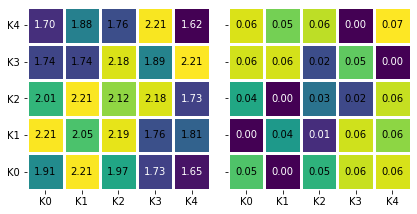

In [4]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policy_ids,
    coplayer_policies=fixed_policy_ids,
    policy_labels={
        "klr_k0_seed0-v0": "K0",
        "klr_k1_seed0-v0": "K1",
        "klr_k2_seed0-v0": "K2",
        "klr_k3_seed0-v0": "K3",
        "klr_k4_seed0-v0": "K4"
    },
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoffs.png"))

## Add Full-Knowledge Best-Response baseline

In [5]:
best_response_map = {
    "klr_k0_seed0-v0": "klr_k1_seed0-v0",
    "klr_k1_seed0-v0": "klr_k2_seed0-v0",
    "klr_k2_seed0-v0": "klr_k3_seed0-v0",
    "klr_k3_seed0-v0": "klr_k4_seed0-v0",
    # FYI K4 is added but is not used in expected results, 
    # since K4 not in other policy prior
    "klr_k4_seed0-v0": "klr_k3_seed0-v0",
}

new_rows = []
for coplayer_policy_id, br_policy_id in best_response_map.items():
    next_exp_id = policy_df["exp_id"].max() + 1
    br_row = policy_df.loc[
        # use results from agent 0 so it's the same as BA-POSGMCP and other baseline results
        (policy_df["agent_id"] == 0)
        & (policy_df["policy_id"] == br_policy_id) 
        & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
    ].copy()
    br_coplayer_row = policy_df.loc[
        (policy_df["agent_id"] == 1)
        & (policy_df["exp_id"].isin(br_row["exp_id"]))
    ].copy()
    # update policy id to baseline name
    br_row["policy_id"] = "full-knowledge-br"
    # update exp ids to avoid duplicates
    br_row["exp_id"] = next_exp_id
    br_coplayer_row["exp_id"] = next_exp_id
    new_rows.append(br_row)
    new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"] == "full-knowledge-br"]
    

10
10
220


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,episode_return_mean,episode_return_std,episode_return_max,episode_return_min,...,episode_return_CI,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,num_sims,truncated,coplayer_policy_id
210,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.20970,0.069720,2.3,2.1,...,0.004321,0.116152,0.038302,0.000,0.0,1.000,0.0,0,False,klr_k0_seed0-v0
212,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21225,0.070869,2.3,2.1,...,0.004393,0.217854,0.036358,0.000,0.0,1.000,0.0,0,False,klr_k1_seed0-v0
214,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.18125,0.298297,2.3,-0.6,...,0.018489,0.133130,0.039960,0.011,0.0,0.989,0.0,0,False,klr_k2_seed0-v0
216,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21325,0.068498,2.3,2.1,...,0.004246,0.102640,0.043274,0.000,0.0,1.000,0.0,0,False,klr_k3_seed0-v0
218,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21435,0.069689,2.3,2.1,...,0.004319,0.104956,0.043259,0.000,0.0,1.000,0.0,0,False,klr_k4_seed0-v0


## Loading BAPOSGMCP Data

In [10]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", f'"{c}",')

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/utils.py:171: DtypeWarning: Columns (8,9,10,13,14,16,17,18,19,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(result_file)


Policies
--------
   POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims1000_actionselectionucb_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionucb_truncatedTrue
   POMetaRollout_greedy_numsims1000_actionselectionuniform_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionuniform_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionucb_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionucb_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionuniform_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionuniform_truncatedTrue
   POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTr

## Combine data

In [11]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_br_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop = True)

def add_alg_id(row):
    pi_id = row["policy_id"]
    if pi_id.startswith("klr"):
        return "fixed"
    tokens = pi_id.split("_")
    alg_id = "_".join([
        t for t in tokens 
        if all(
            s not in t for s in [
                "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "piklr"
            ]
        )
    ])
    return alg_id


def add_meta_pi(row):
    pi_id = row["policy_id"]
    for meta_pi in ["greedy", "softmax", "uniform"]:
        if meta_pi in pi_id:
            return meta_pi
    return "NA"


combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)

print(combined_df["action_selection"].unique())

# Drop unused policies
# These are from seed0 which contained different action selection and truncated search values
# used for v1 analysis
combined_df = combined_df[
    (combined_df["action_selection"].isin(["pucb", 'None', np.nan]))
    & (
        (combined_df["alg_id"].isin(["baposgmcp_random", "fixed", "full-knowledge-br", "metabaseline"]))
        | (combined_df["truncated"] == True)
        | (
            (combined_df["alg_id"] == "POMeta") & (combined_df["meta_pi"] == "greedy")
        )
    )
]
    
policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print(f'    "{pi_id}",')
    
alg_ids = combined_df["alg_id"].unique().tolist()
alg_ids.sort()
print("\nAlg IDs")
print("-------")
for n in alg_ids:
    print("  ", n)
    
print("\nMeta Pis:")
print("---------")
print(combined_df["meta_pi"].unique().tolist())

print("\nColumns")
print("-------")
for c in combined_df.columns:
    print("  ", c)

['pucb' 'ucb' 'uniform' nan 'None']
Policies
--------
    "POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue",
    "POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue",
    "POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTrue",
    "POMetaRollout_greedy_numsims500_actionselectionpucb_truncatedTrue",
    "POMetaRollout_greedy_numsims50_actionselectionpucb_truncatedTrue",
    "POMetaRollout_softmax_numsims1000_actionselectionpucb_truncatedTrue",
    "POMetaRollout_softmax_numsims100_actionselectionpucb_truncatedTrue",
    "POMetaRollout_softmax_numsims10_actionselectionpucb_truncatedTrue",
    "POMetaRollout_softmax_numsims500_actionselectionpucb_truncatedTrue",
    "POMetaRollout_softmax_numsims50_actionselectionpucb_truncatedTrue",
    "POMetaRollout_uniform_numsims1000_actionselectionpucb_truncatedTrue",
    "POMetaRollout_uniform_numsims100_actionselectionpucb_truncatedTrue",
    "POMetaRollout_uniform_numsims10_actionselectionpucb_truncat

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

(<Figure size 1440x5328 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

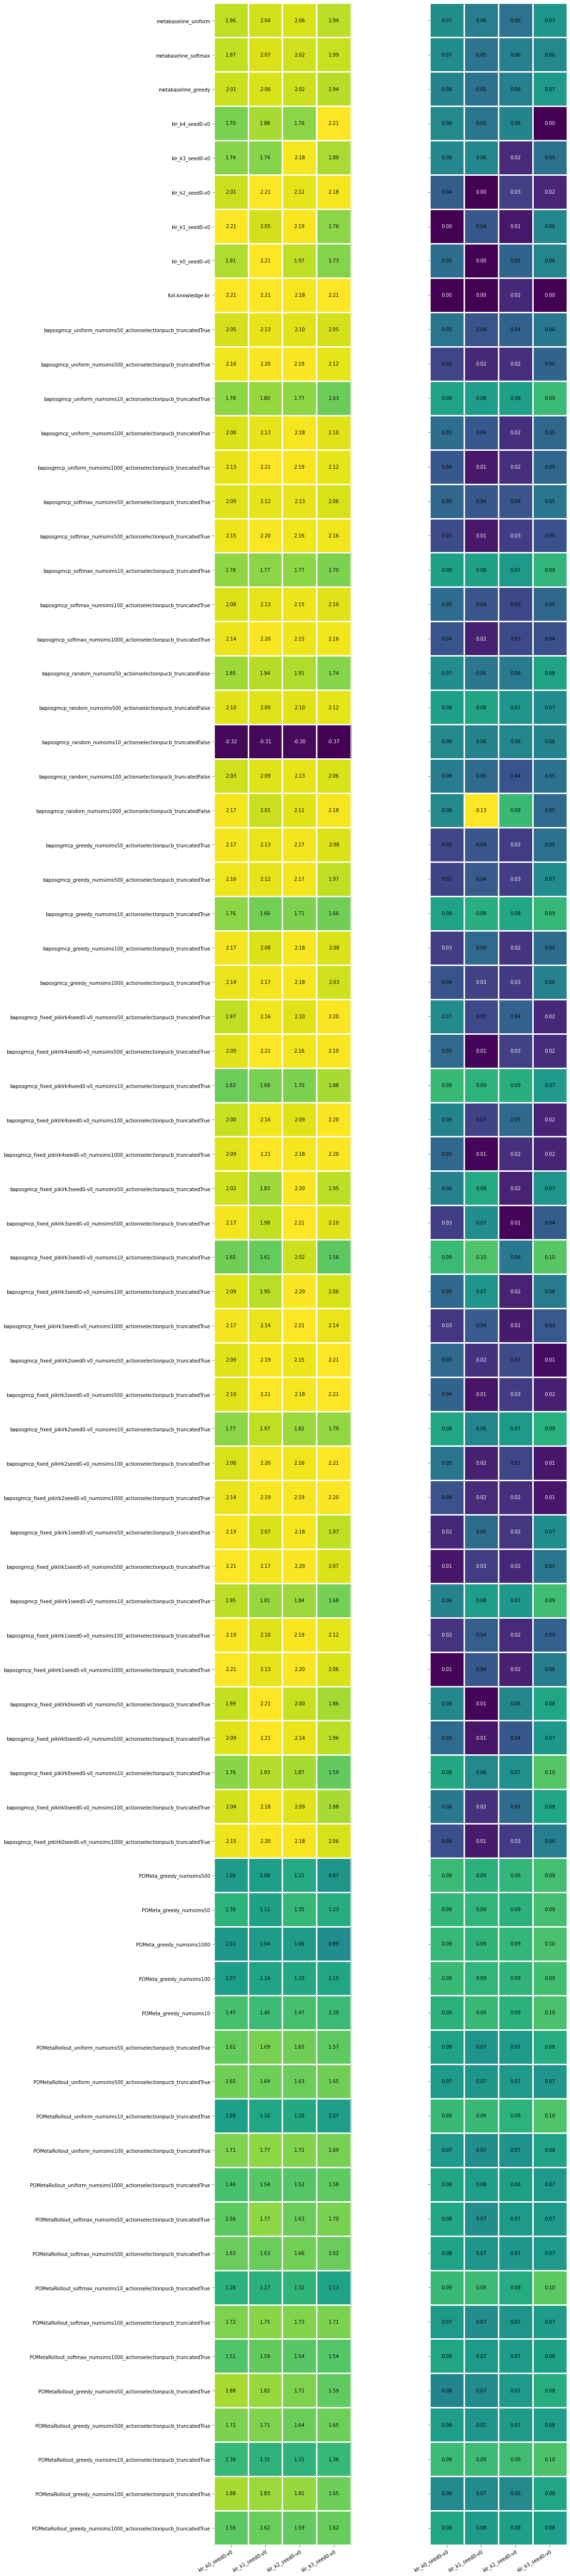

In [12]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(20, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1440x5328 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

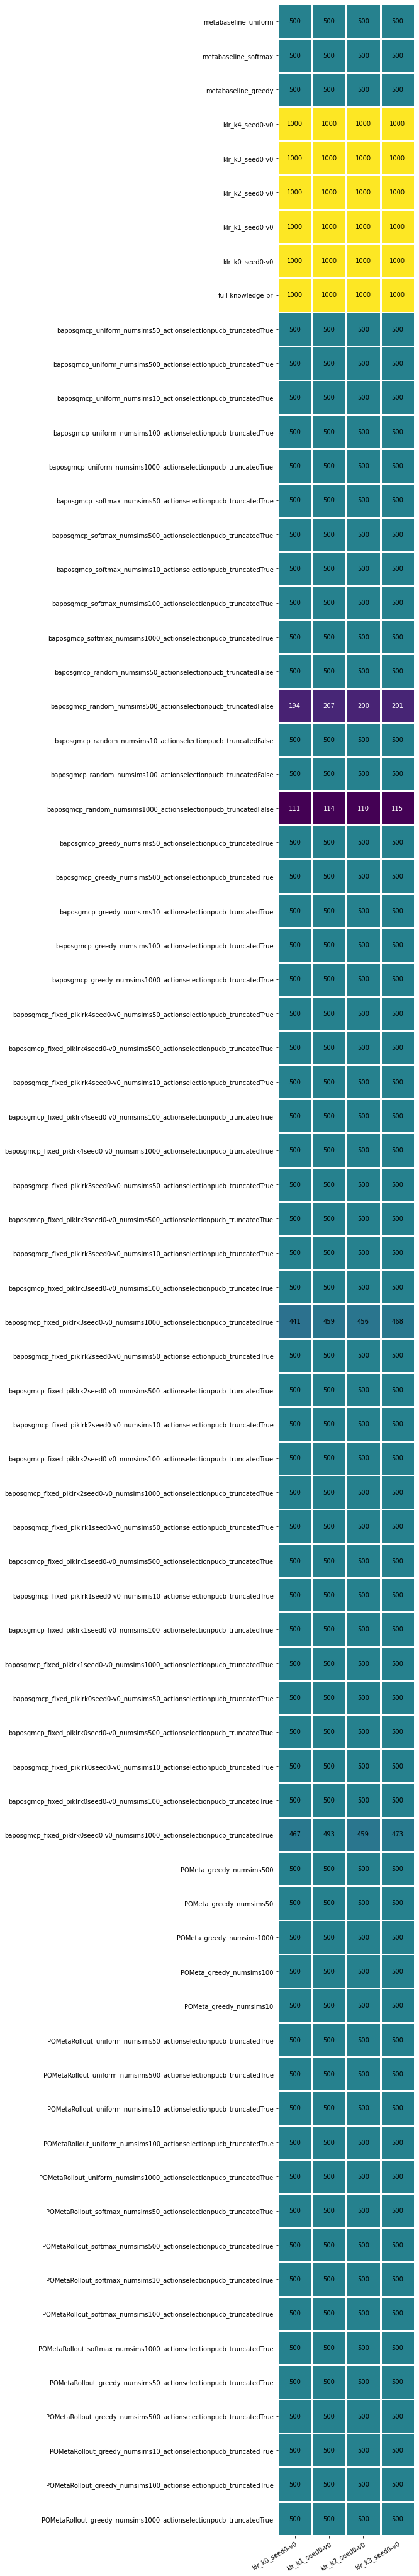

In [13]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.0f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

## Policy Prior Performance

Here we look at the expected performance against the policy prior of BAPOSGMCP.

In [14]:
exp_df = plot_utils.get_uniform_expected_df(
    combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)

Ungrouped size = 320
Grouped size = 74


In [15]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

### Action Selection

In [16]:
exp_df["action_selection"].unique()

array(['pucb', None], dtype=object)

## Comparison of truncation

In [17]:
exp_df["truncated"].unique()

array([ True, False])

## Comparison of the different Meta-Policies

In [18]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["POMeta", "metabaseline"]))
        | (
            (exp_df["alg_id"].isin(["baposgmcp", "POMetaRollout"])) & (exp_df["truncated"] == True)
        )
    )
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
metabaseline

Policy IDs
----------
POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims500_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims50_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims1000_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims100_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims10_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims500_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims50_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims1000_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims100_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims10_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims500_actionselectionpucb_

POMeta
POMetaRollout
baposgmcp
metabaseline


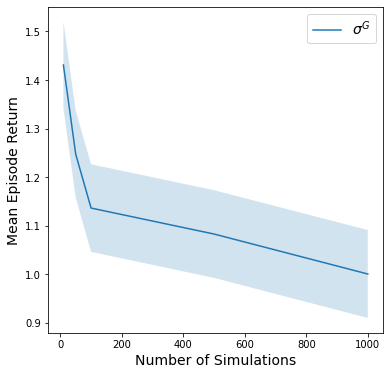

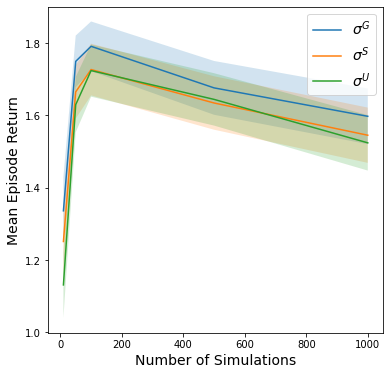

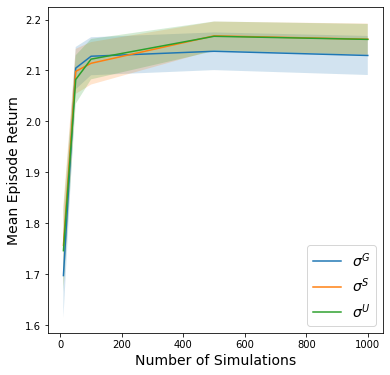

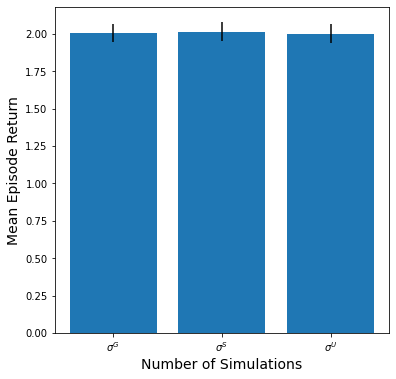

In [19]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (1.5, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    # "loc": "lower right",
    # "title": "Meta-Policy" 
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp
metabaseline


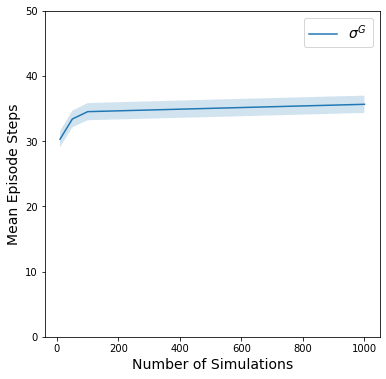

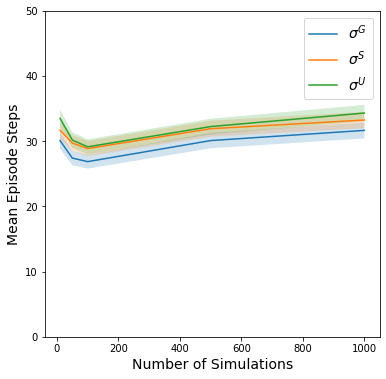

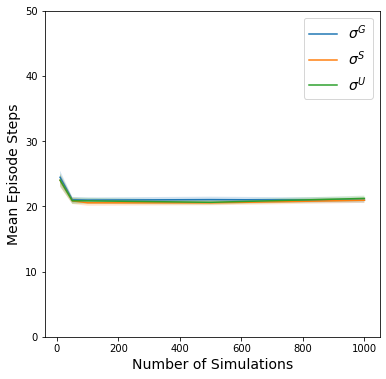

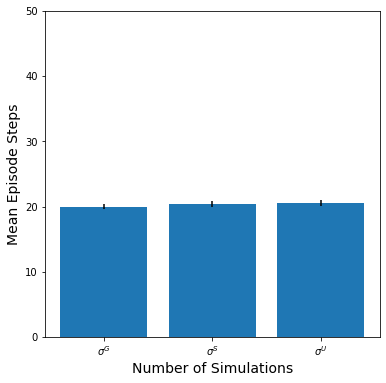

In [33]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper right',
    # "title": "Meta-Policy",  
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"meta_pi_step_{alg_id}.png"))
    
del plot_kwargs

## Comparing Meta-Policy versus no meta-policy

Here we look at the performance of BAPOSGMCP (using PUCB) with using a meta-policy against not using a meta-policy (i.e. using the different fixed policies).

In [22]:
meta_vs_no_pi_label_map = {
    "baposgmcp_softmax": r"$\sigma^{S}$",
    "baposgmcp_random": "Random",
    "baposgmcp_fixed_piklrk0seed0-v0": "K0", 
    "baposgmcp_fixed_piklrk1seed0-v0": "K1", 
    "baposgmcp_fixed_piklrk2seed0-v0": "K2",
    "baposgmcp_fixed_piklrk3seed0-v0": "K3",
    "baposgmcp_fixed_piklrk4seed0-v0": "K4"
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random"]))
    # (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (
        (exp_df["alg_id"] == "baposgmcp_random") | (exp_df["truncated"] == True)
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp_fixed
baposgmcp_random

Policy IDs
----------
baposgmcp_fixed_piklrk0seed0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims50_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims50_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk2seed0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk2seed0-v0_numsims100_actionselectionpucb_truncated

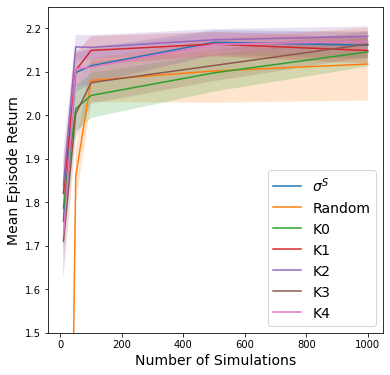

In [38]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (1.5, 2.25)
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return.png"))
    
del plot_kwargs

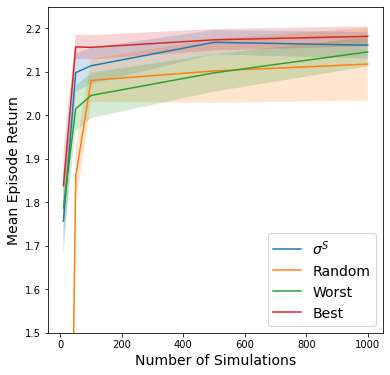

In [37]:
meta_vs_no_best_and_worst_pi_label_map = {
    "baposgmcp_softmax": r"$\sigma^{S}$",
    "baposgmcp_random": "Random",
    "baposgmcp_fixed_piklrk0seed0-v0": "Worst", 
    # "baposgmcp_fixed_piklrk1seed0-v0": "K1", 
    "baposgmcp_fixed_piklrk2seed0-v0": "Best",
    # "baposgmcp_fixed_piklrk3seed0-v0": "K3",
    # "baposgmcp_fixed_piklrk4seed0-v0": "K4"
}

plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (1.5, 2.25),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_best_and_worst_pi_label_map)],
    pi_label_map=meta_vs_no_best_and_worst_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_best_and_worst.png"))
    
del plot_kwargs

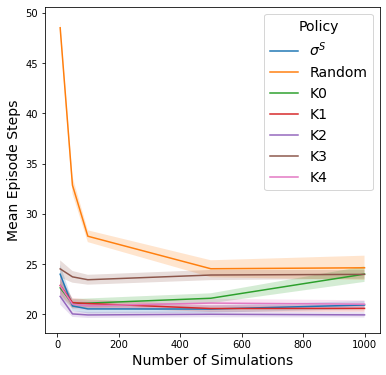

In [27]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (18, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "upper right",
    "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_steps.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines

In [28]:
perf_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["POMeta", "metabaseline", "full-knowledge-br"]))
        | ((exp_df["alg_id"].isin(["baposgmcp", "POMetaRollout"])) & (exp_df["truncated"] == True))
    )
]

policy_prefixes_to_plot = [
    "baposgmcp_softmax",
    "POMeta_greedy",
    "POMetaRollout_greedy",
    "metabaseline_greedy",
    "full-knowledge-br"
]

baseline_pi_label_map = {
    "baposgmcp_softmax": "BAPOSGMCP",
    "baposgmcp_random": "BAPOSGMCP Random",
    "POMeta_greedy": "POMeta", 
    "POMetaRollout_greedy": "POMetaRollout", 
    "metabaseline_greedy": "Meta-Policy",
    "full-knowledge-br": "Best-Response"
}

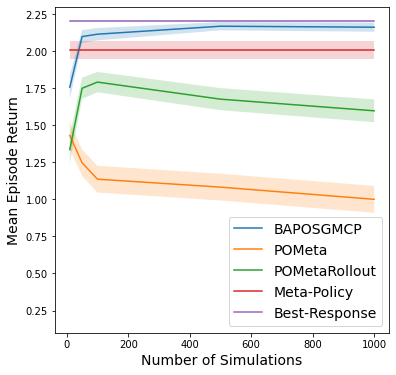

In [29]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.1, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    perf_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "baselines_return.png"))
    
del plot_kwargs

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [30]:
belief_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["POMeta"]))
        | ((exp_df["alg_id"].isin(["baposgmcp", "POMetaRollout"])) & (exp_df["truncated"] == True))
    )
    
]

belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "num_sims"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in belief_group_keys:
    if k in belief_agg_dict:
        belief_agg_dict.pop(k)
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["num_sims"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))
# print(belief_gb_df)

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
Ungrouped size = 35
Grouped size = 15


In [31]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    # "title": "Num. Sims." 
})

POMeta
POMetaRollout
baposgmcp


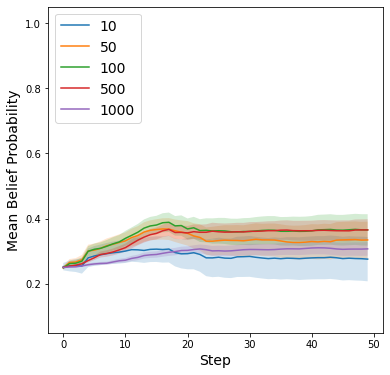

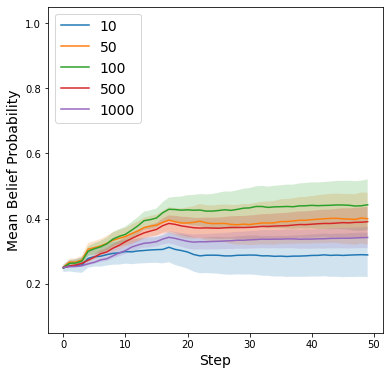

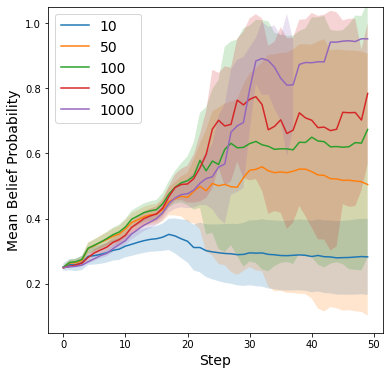

In [32]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Probability",
    "ylim": (0.05, 1.05),
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="bayes_accuracy",
        step_limit=50,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )

    fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp


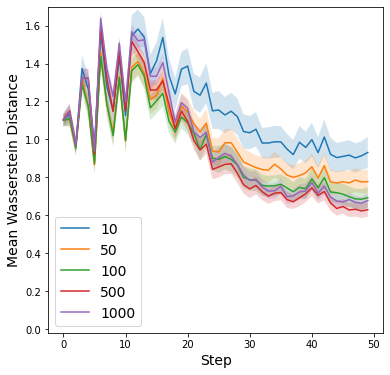

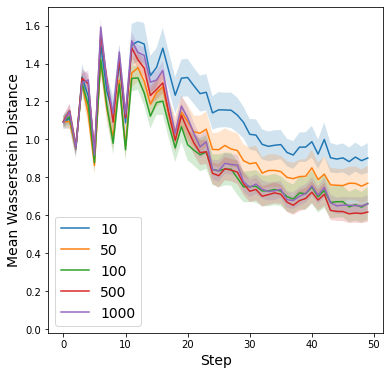

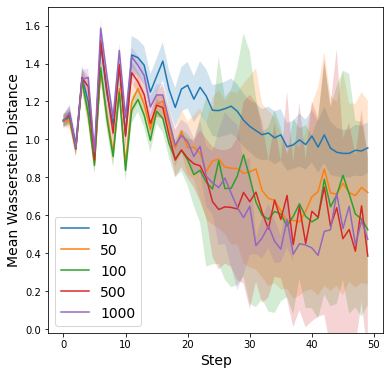

In [57]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Wasserstein Distance",
    "ylim": (-0.02, 1.7),
})

plot_kwargs["legend_kwargs"].update({
    "loc": "lower left",
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="action_dist_distance",
        step_limit=50,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )

    fig.savefig(osp.join(figure_dir, f"action_dist_{alg_id}.png"))
    
del plot_kwargs

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [34]:
times_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', None]))
    & (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random", "POMetaRollout", "POMeta"]))
]

print(times_df["truncated"].unique())

times_group_keys = ["alg_id", "truncated", "num_sims"]
times_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in times_group_keys:
    if k in times_agg_dict:
        times_agg_dict.pop(k)
    
times_agg_dict["policy_id"] = pd.NamedAgg(column="policy_id", aggfunc="first")
        
gb = times_df.groupby(times_group_keys)
gb_agg = gb.agg(**times_agg_dict)
times_gb_df = gb_agg.reset_index()

times_gb_df.sort_values(by=["alg_id", "truncated", "num_sims"], inplace=True)

print("Ungrouped size =", len(times_df))
print("Grouped size =", len(times_gb_df))

times_alg_ids = times_gb_df["alg_id"].unique().tolist()
times_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in times_alg_ids:
    print(n)
    
times_policy_ids = times_gb_df["policy_id"].unique().tolist()
times_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in times_policy_ids:
    print(n)
    
    
# based on output of policy IDs (since we group IDS)
time_pi_label_map = {
    # "baposgmcp_uniform": r"BAPOSGMCP",
    # "baposgmcp_softmax": r"BAPOSGMCP",
    "baposgmcp_greedy": r"BAPOSGMCP",
    # "baposgmcp_random": "BAPOSGMCP Random",
    # "baposgmcp_fixed": "BAPOSGMCP Fixed",
    "POMeta": "POMeta", 
    "POMetaRollout": "POMetaRollout", 
    # "metabaseline": "Meta-Policy",
}

sim_policies = [
    # "baposgmcp_uniform",
    # "baposgmcp_softmax",
    "baposgmcp_greedy",
    # "baposgmcp_random",
    # "baposgmcp_fixed",
    "POMetaRollout", 
]

[ True False]
Ungrouped size = 65
Grouped size = 25
Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random

Policy IDs
----------
POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims500_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims50_actionselectionpucb_truncatedTrue
POMeta_greedy_numsims10
POMeta_greedy_numsims100
POMeta_greedy_numsims1000
POMeta_greedy_numsims50
POMeta_greedy_numsims500
baposgmcp_fixed_piklrk0seed0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims50_actionselectionpucb_truncatedTrue
baposgmc

POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


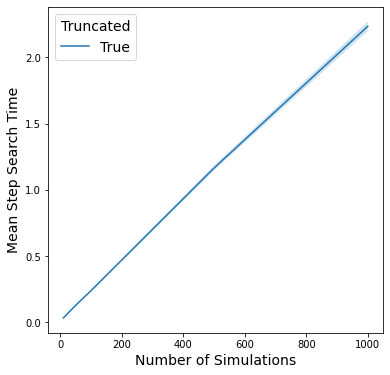

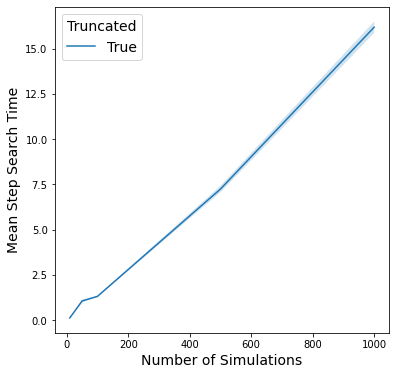

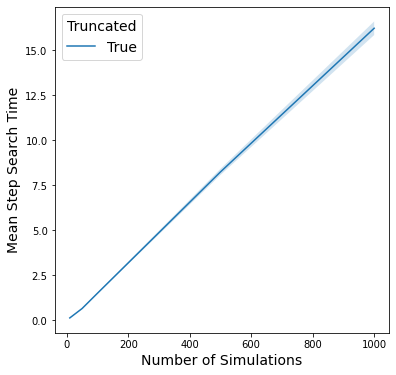

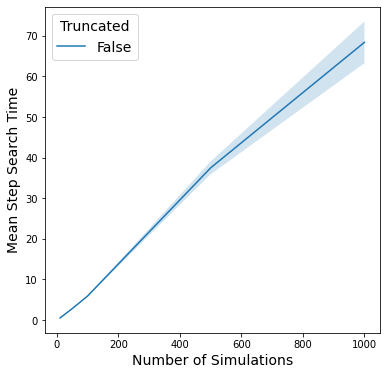

In [36]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Step Search Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    if alg_id == "POMeta":
        continue
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="search_time_mean",
        y_err_key="search_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_search_time_{alg_id}.png"))
    
del time_plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


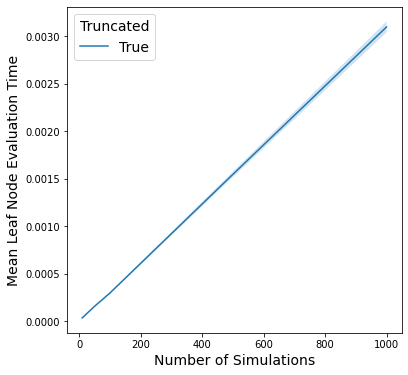

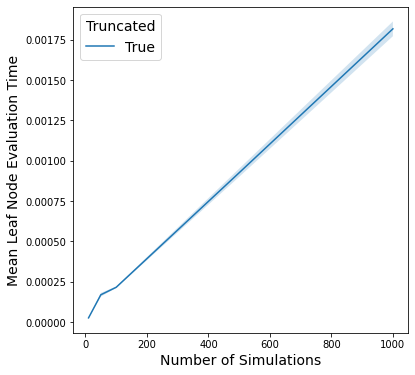

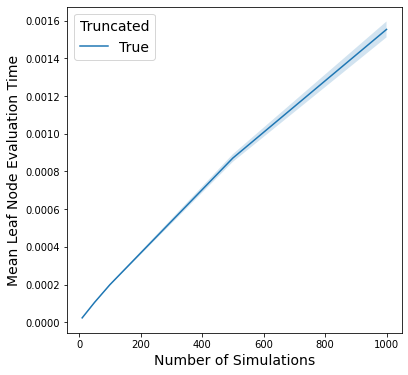

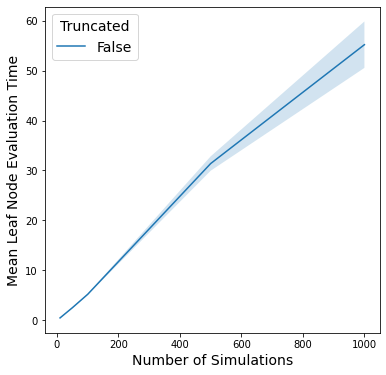

In [37]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Leaf Node Evaluation Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    if alg_id == "POMeta":
        continue
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="evaluation_time_mean",
        y_err_key="evaluation_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_eval_time_{alg_id}.png"))
    
del time_plot_kwargs

POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


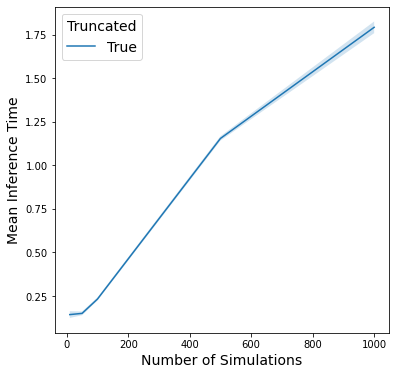

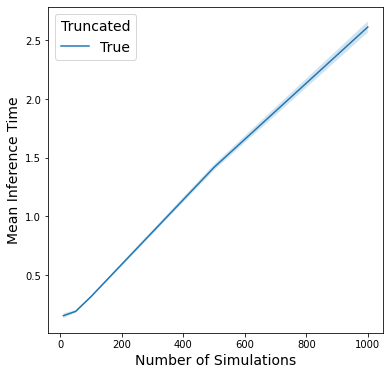

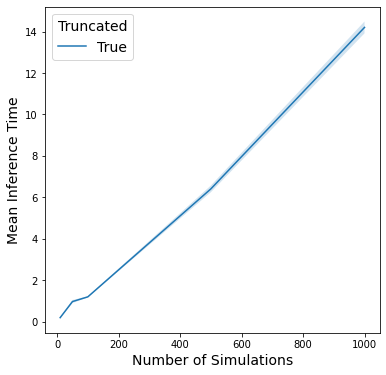

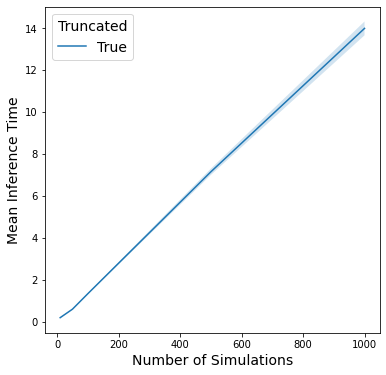

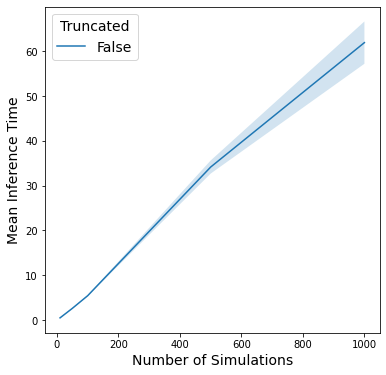

In [38]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Inference Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="inference_time_mean",
        y_err_key="inference_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_inference_time_{alg_id}.png"))
    
del time_plot_kwargs

POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


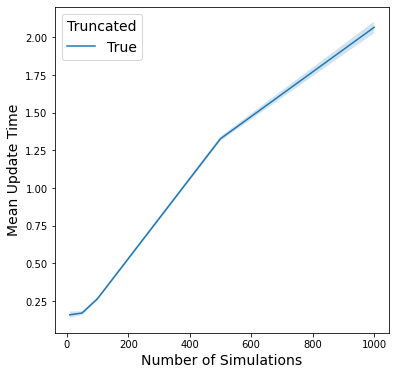

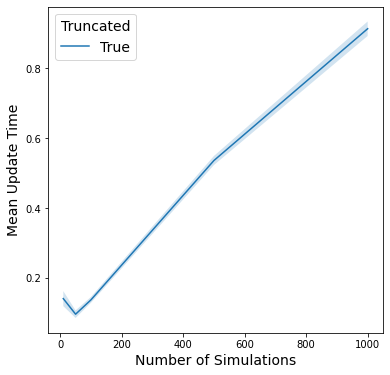

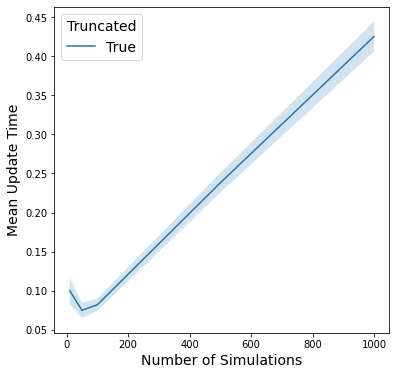

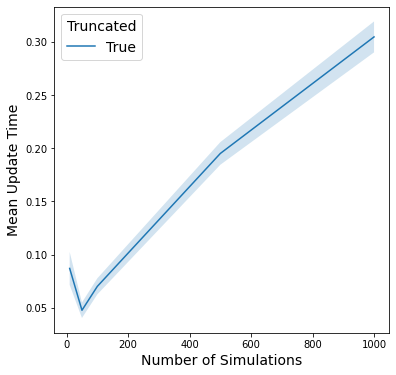

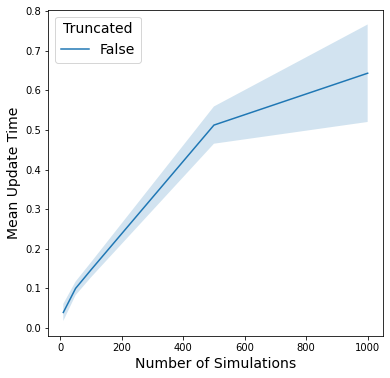

In [39]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Update Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="update_time_mean",
        y_err_key="update_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_update_time_{alg_id}.png"))
    
del time_plot_kwargs

POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


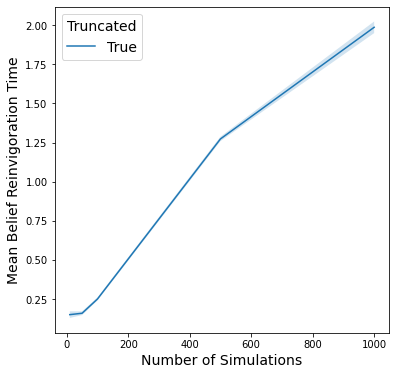

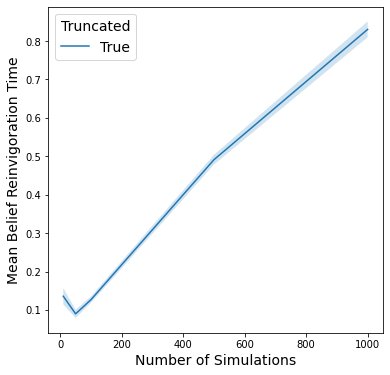

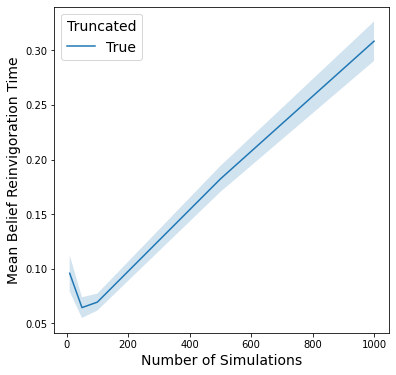

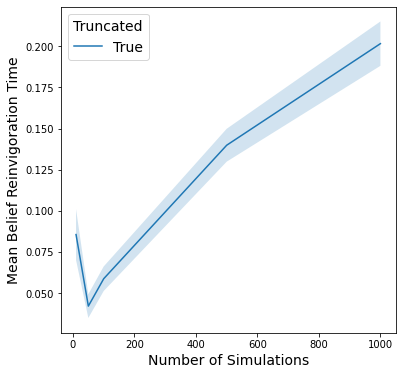

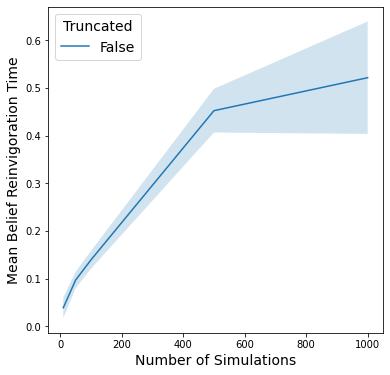

In [40]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Reinvigoration Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="reinvigoration_time_mean",
        y_err_key="reinvigoration_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_reinvigoration_time_{alg_id}.png"))
    
del time_plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


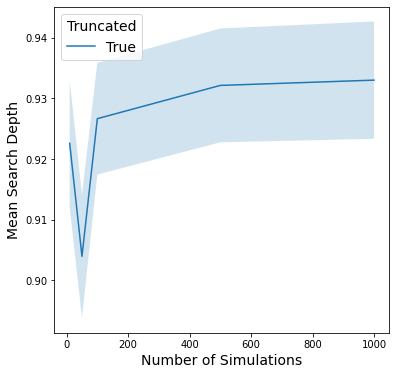

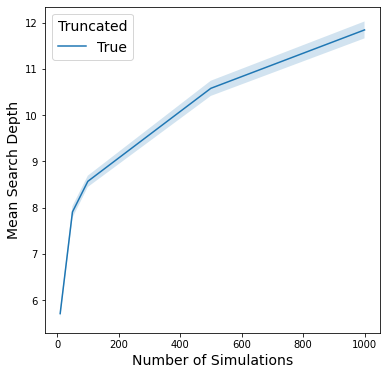

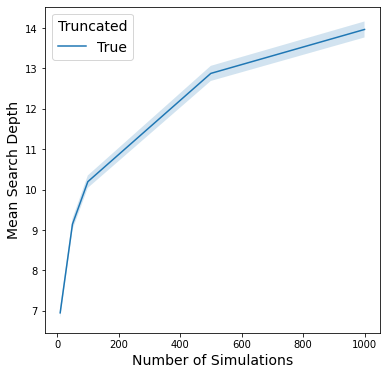

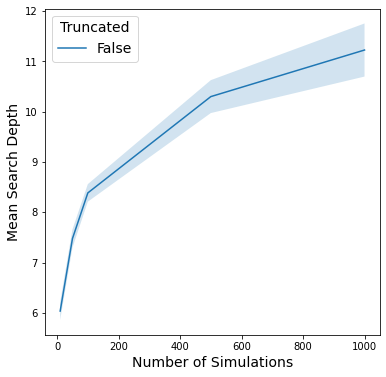

In [41]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Search Depth",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    if alg_id == "POMeta":
        continue
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="search_depth_mean",
        y_err_key="search_depth_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_search_depth_{alg_id}.png"))
    
del time_plot_kwargs